In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, Action_Scheduler, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

import matplotlib.pyplot as plt
%matplotlib notebook

from train import load_model

In [2]:
env = RLTe.RLtractEnvironment(stepWidth=1, action_space=20, maxL2dist_to_State=0.2, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
#env = RLTe.RLtractEnvironment(stepWidth=0.3, action_space=20, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_min40.vtk) for ID 100307


In [ ]:
next_state = env.reset(50)
for i in range (20):
    cur_state = next_state
       
    action = env._get_best_action()
    next_state, reward, terminal, _ = env.step(action)
    ### cdist broken ??
    
    dist = env.minDistToStreamline(env.line, next_state)
    #distances = torch.cdist(torch.FloatTensor([env.line.coords[:]]), next_state.getCoordinate().unsqueeze(dim=0).float(), p=2,).squeeze(0)
    l2_distance = dist
    
    print("%d %s => %s | c = %.1f, d = %.1f" % (action, str(cur_state.getCoordinate().cpu().detach().numpy()), str(next_state.getCoordinate().cpu().detach().numpy()), reward, l2_distance))

In [3]:
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 

In [4]:
state = env.reset().getValue()
print(state.shape)
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

(100, 3, 3, 3)


Loading checkpoint from test_newReward/checkpoints/defi_16684_135.71.pt


<All keys matched successfully>

In [ ]:
#### Fill replay memory with perfect actions for supervised approach

from tqdm import trange
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

overall_runs = 0
overall_reward = []
for overall_runs in trange(60):
    state = env.reset(streamline_index=overall_runs)
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    #print("New run")
    #print(env.stepCounter, state.getCoordinate().numpy())
    while not terminal:
        #print(env.stepCounter)
        #if np.random.rand(1) < 0.1: 
        #    action = np.random.randint(0, n_actions)
        #else:
        action = env._get_best_action()
        next_state, reward, terminal, _ = env.step(action)
        
            
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward = reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

Training cell

In [ ]:
torch.optim.Adam(agent.target_dqn.parameters(), 0.0001)
losses = []
for i in trange(70000):
    states, actions, _, _, _ = agent.replay_memory.get_minibatch()

    states = torch.FloatTensor(states).to(agent.device)
    actions = torch.LongTensor(actions).to(agent.device)
    predicted_q = agent.main_dqn(states)
    loss = torch.nn.functional.cross_entropy(predicted_q, actions)
    #print(loss.item())
    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    losses.append(loss.item())
    
mean_losses = []
for i in range(len(losses)):
    mean_losses.append(np.mean(losses[i:i+99]))
#print(mean_losses[-20:])

fig, ax = plt.subplots()
ax.plot(range(len(losses[:])), losses[:])
ax.plot(range(len(losses[:])), mean_losses[:])
plt.show()

# Debug data  generation

In [ ]:
import os, sys

import gym
from gym.spaces import Discrete, Box
import numpy as np

from dipy.data import get_sphere
from dipy.data import HemiSphere, Sphere
from dipy.core.sphere import disperse_charges
import torch


from dfibert.data.postprocessing import res100, resample
from dfibert.data import HCPDataContainer, ISMRMDataContainer, PointOutsideOfDWIError
from dfibert.tracker import StreamlinesFromFileTracker
from dfibert.util import get_grid

import shapely.geometry as geom
from shapely.ops import nearest_points
from shapely.strtree import STRtree


from collections import deque

dataset = HCPDataContainer('100307')
dataset.normalize()

In [ ]:
coord, data = next_state.getCoordinate(), next_state.getValue()

In [ ]:
dwi_postprocessor = resample(sphere=get_sphere('repulsion100'))

In [ ]:
grid = get_grid(np.array([3,3,3]))
ras_points = dataset.to_ras(coord)

ras_points = grid + ras_points

interpolated_dwi = dataset.get_interpolated_dwi(ras_points, postprocessing=dwi_postprocessor)
interpolated_dwi = np.rollaxis(interpolated_dwi,3)

In [ ]:
distances = torch.cdist(torch.FloatTensor([env.line.coords[:]]), next_state.getCoordinate().unsqueeze(dim=0).float(), p=2,).squeeze(0)
torch.min(distances)

In [ ]:
next_state.getCoordinate().numpy()

In [ ]:
action

In [ ]:
reward

In [ ]:
cur_state.getCoordinate(), next_state.getCoordinate()

In [ ]:
fig = plt.figure()
si = interpolated_dwi[1,:,:,0]
plt.imshow(si)
plt.colorbar()

In [ ]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

In [ ]:
step_counter = 0
eps_rewards = []
episode_lengths = []

eps = 1.0

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        episode_reward_sum = 0
        terminal = False
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        negative_rewards = 0
        
        
        # reduce epsilon
        if step_counter > start_learning:
            eps = max(eps * 0.999, 0.01)
        
        # play an episode
        while episode_step_counter <= 1000.:
            
            # get an action with epsilon-greedy strategy
            if random.random() < eps:                                 
                action = np.random.randint(env.action_space.n)           # either random action
                #action = env._get_best_action()
            else:                                                        # or action from agent
                agent.main_dqn.eval()
                with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                agent.main_dqn.train()
            
            # perform step on environment
            next_state, reward, terminal, _ = env.step(action)

            
            episode_step_counter += 1
            step_counter += 1
            epoch_step += 1
            
            episode_reward_sum += reward
            
            # store experience in replay buffer
            agent.replay_memory.add_experience(action=action, state = state.getValue(), reward=reward, new_state = next_state.getValue(), terminal=terminal)
            
            state = next_state
            
            # optimize agent after certain amount of steps
            if step_counter > start_learning and step_counter % 4 == 0:
                
                # original optimization function
                #agent.optimize()
                
                ### debugging optimization function
                
                states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
                
                #states = torch.tensor(states)#.view(replay_memory.batch_size, -1) # 1, -1
                #next_states = torch.tensor(new_states)#.view(replay_memory.batch_size, -1)
                #actions = torch.LongTensor(actions)
                #rewards = torch.tensor(rewards)
                #terminal_flags = torch.BoolTensor(terminal_flags)

                states = torch.from_numpy(states).to(device)
                next_states = torch.from_numpy(new_states).to(device)
                actions = torch.from_numpy(actions).unsqueeze(1).long().to(device)
                rewards = torch.from_numpy(rewards).to(device)
                terminal_flags = torch.from_numpy(terminal_flags).to(device)
                
                
                state_action_values = agent.main_dqn(states).gather(1, actions).squeeze(-1)
                next_state_actions = torch.argmax(agent.main_dqn(next_states), dim=1)
                next_state_values = agent.target_dqn(next_states).gather(1, next_state_actions.unsqueeze(-1)).squeeze(-1)
                #
                next_state_values[terminal_flags] = 0.0
                #
                expected_state_action_values = next_state_values.detach() * 0.9995 + rewards
                #
                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
                agent.optimizer.zero_grad()
                loss.backward()
                agent.optimizer.step()
                
            # update target network after certain amount of steps    
            if step_counter > start_learning and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if epsiode has ended, step out of the episode while loop
            if terminal:
                break
                
        # keep track of past episode rewards
        eps_rewards.append(episode_reward_sum)
        if len(eps_rewards) % 20 == 0:
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), eps))#action_scheduler.eps_current))
            
    ## evaluation        
    eval_rewards = []
    episode_final = 0
    agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        
        eval_episode_reward = 0
        negative_rewards = 0
        
        # play an episode
        while eval_steps < 1000:
            # get the action from the agent
            with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                  
            # perform a step on the environment
            next_state, reward, terminal, _ = env.step(action)
            
            eval_steps += 1
            
            eval_episode_reward += reward
            state = next_state
            
            # step out of the episode while loop if 
            if terminal:
                terminal = False
                if reward == 1.:
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))

# Evaluation of trained agent

In [24]:
import glob
paths = glob.glob('test_newReward/checkpoints/*.pt') # new reward with penalty when leaving brain mask

p_cp = max(paths, key=os.path.getctime)
model, step_counter, mean_reward, epsilon = load_model(p_cp)

agent.main_dqn.load_state_dict(model)
agent.target_dqn.load_state_dict(model)

Loading checkpoint from test_newReward/checkpoints/defi_38258_123.49.pt


<All keys matched successfully>

In [25]:
eval_rewards = []
all_distances = []
all_states = []
l2s = []
max_episode_length = 300
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=50)    
    #state = env.reset()
    #print(state.getCoordinate())
    all_states.append(state.getCoordinate())
    #transition = init_transition()
    #all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    #print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        #action = torch.argmax(main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
        #action = env._get_best_action()
        with torch.no_grad():
            state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
            action = torch.argmax(agent.main_dqn(state_v)).item()
        next_state, reward, terminal, _ = env.step(action)
        
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])].numpy(), reward)       
        eval_steps += 1
        
        #if(env.line.distance(geom.Point(next_state.getCoordinate())) > 0.1):
        #    print("We left our streamline. Switching to closest one")
        #    break
        l2s.append(env.l2_distance.detach().cpu().numpy())
        
        if eval_steps == 1000:
            terminal = True
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        
        #if(isPointOnStreamline(tree, next_state.getCoordinate(), env.line) == False):
        #    print("[%d] Oh noes, we left our streamline :()" % (eval_steps))
        
        state = next_state
        if terminal:
            terminal = False
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

0 12 [ 57.58526376 111.03187755 101.46242623] [ 57.485153 111.210014 101.54831 ] tensor(0.9836, dtype=torch.float64)
1 12 [ 58.08508592 110.49028403 100.78651628] [ 58.0384   110.8796   101.074234] tensor(0.9212, dtype=torch.float64)
2 12 [ 58.58490809 109.94869051 100.11060633] [ 58.64283 110.52157 100.69152] tensor(0.8474, dtype=torch.float64)
3 1 [ 59.37817042 109.83481725  99.51246943] [ 59.144703 110.328384 100.099236] tensor(0.9459, dtype=torch.float64)
4 12 [ 59.87799258 109.29322372  98.83655948] [ 59.646572 110.13519   99.50694 ] tensor(0.8306, dtype=torch.float64)
5 4 [ 60.14289994 109.27706765  97.87242097] [ 60.0676   109.980446  98.844536] tensor(0.8383, dtype=torch.float64)
6 4 [ 60.4078073  109.26091157  96.90828245] [ 60.29683 109.92374  98.08018] tensor(0.8063, dtype=torch.float64)
7 4 [ 60.67271465 109.24475549  95.94414394] [ 60.423702 109.92041   97.29031 ] tensor(0.7232, dtype=torch.float64)
8 4 [ 60.93762201 109.22859941  94.98000543] [ 60.45151 109.97005  96.4923

#74 12 [74.5265052  84.03591801 82.55710563] [ 80.05306  124.94337   61.650837] tensor(0.2129, dtype=torch.float64)
75 3 [74.96497234 83.2208627  82.93582903] [ 80.06689 125.43866  61.02275] tensor(0.7746, dtype=torch.float64)
76 16 [74.46770485 82.35868779 83.03267668] [ 79.989975 125.87924   60.359444] tensor(0.5759, dtype=torch.float64)
77 12 [74.96752702 81.81709427 82.35676673] [ 79.91461  126.211426  59.635586] tensor(0.9143, dtype=torch.float64)
78 16 [74.47025952 80.95491936 82.45361438] [ 79.74536  126.36652   58.869232] tensor(0.6838, dtype=torch.float64)
#79 16 [73.97299203 80.09274445 82.55046202] [ 79.579185 126.408424  58.087803] tensor(0.2150, dtype=torch.float64)
#80 14 [74.12481077 79.65879396 83.43851497] [73.3368  78.30929 87.03436] tensor(0.2579, dtype=torch.float64)
#81 16 [73.62754328 78.79661905 83.53536262] [73.33464 96.41909 77.07555] tensor(0.1552, dtype=torch.float64)
82 12 [74.12736545 78.25502553 82.85945267] [73.33464 96.41909 77.07555] tensor(0.8482, dtyp

#146 12 [ 52.83178924  91.67590022 120.16354786] [57.936996 89.119194 93.30337 ] tensor(-48.7727, dtype=torch.float64)
#147 9 [ 52.85051498  92.1482993  121.04473369] [58.199432 89.02932  94.053734] tensor(-55.7614, dtype=torch.float64)
#148 9 [ 52.86924072  92.62069837 121.92591951] [58.461864 88.93944  94.8041  ] tensor(-63.4169, dtype=torch.float64)
#149 9 [ 52.88796646  93.09309745 122.80710534] [58.63112 88.78433 95.57045] tensor(-71.7390, dtype=torch.float64)
#150 9 [ 52.9066922   93.56549652 123.68829117] [58.800373 88.629234 96.33681 ] tensor(-80.7278, dtype=torch.float64)
#151 9 [ 52.92541794  94.0378956  124.56947699] [58.873444 88.52675  97.12684 ] tensor(-90.3832, dtype=torch.float64)
#152 9 [ 52.94414368  94.51029467 125.45066282] [58.946514 88.42426  97.91688 ] tensor(-100.7053, dtype=torch.float64)
#153 9 [ 52.96286942  94.98269375 126.33184865] [58.918705 88.374626 98.71485 ] tensor(-111.6941, dtype=torch.float64)
#154 9 [ 52.98159516  95.45509282 127.21303447] [58.8908

In [26]:
state = env.reset(streamline_index=50) 
state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
res = agent.main_dqn(state_v)
x = res.cpu().detach().numpy().squeeze()

<IPython.core.display.Javascript object>


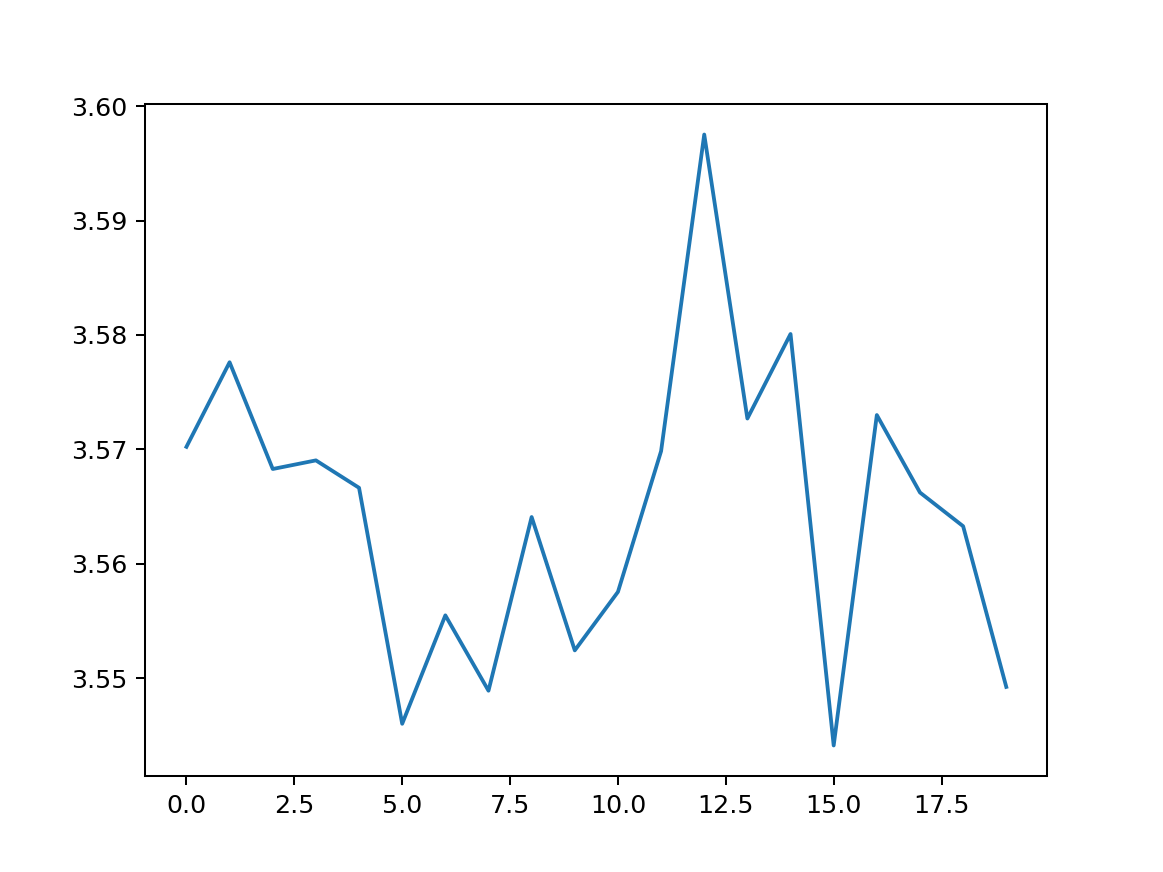

In [27]:
fig = plt.figure()
plt.plot(range(20), np.array(x))
plt.show()

<IPython.core.display.Javascript object>


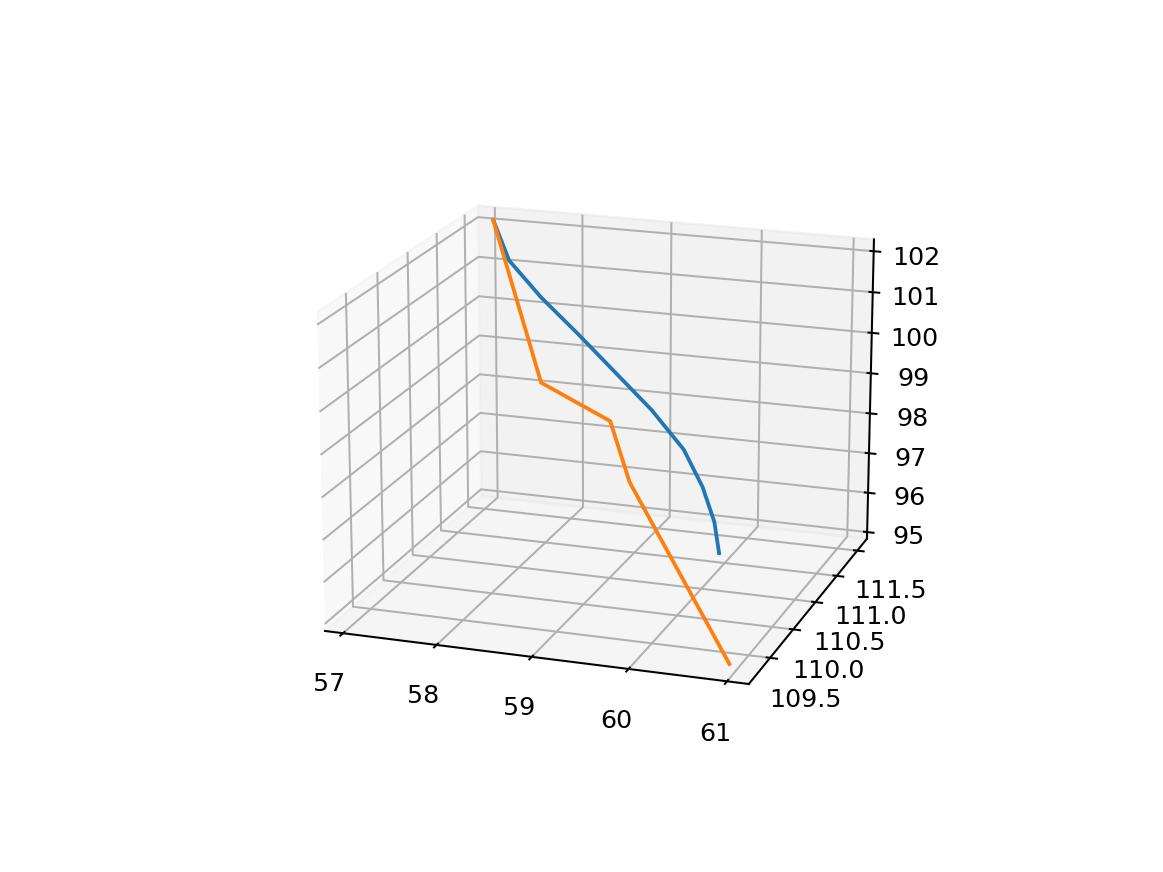

In [28]:
### visualise streamline
%matplotlib notebook 
state = env.reset(streamline_index=50) 

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][0:10], env.referenceStreamline_ijk.T[1][0:10], env.referenceStreamline_ijk.T[2][0:10])
ax.plot3D(states.T[0][0:10], states.T[1][0:10], states.T[2][0:10])